# Análisis exploratorio de datos (EDA)

In [ ]:
!apt-get install libgeos-dev
#!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6
!pip install fasttext
!python -m spacy download pt
!pip install tensorflow_addons
!pip install basemap

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import spacy
import regex as re
from datetime import datetime
from tqdm import tqdm
import pickle
import scipy
from mpl_toolkits.basemap import Basemap
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, log_loss
import fasttext.util
import warnings
from tensorflow_addons.metrics import F1Score
from sklearn.utils.extmath import randomized_svd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Embedding, LSTM, Flatten, Concatenate, Reshape, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from xgboost import XGBClassifier
from prettytable import PrettyTable
from keras.models import load_model
from sklearn.metrics import plot_confusion_matrix


warnings.filterwarnings("ignore")
sns.set_theme(style="darkgrid")

## Exploración, limpieza y transformación de los datos

A continuación se realiza la visualización y exploración de cada una de las tablas que componen la base de datos. Para cada tabla se visualiza la información, las primeras filas, el porcentaje de valores nulos. En algunas tablas debido a su contenido se realiza exploración de datos adicional.

In [3]:
#Access drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# Reading all the files
raw_path = '/content/drive/MyDrive/ColabNotebooks/06_MetodologiasAgiles/Project/output_folder/'
#raw_path ='/content/drive/MyDrive/Colab Notebooks/06_MetodologiasAgiles/Project/output_folder/'
olist_customer = pd.read_csv(raw_path + 'olist_customers_dataset.csv')
olist_geolocation = pd.read_csv(raw_path + 'olist_geolocation_dataset.csv')
olist_orders = pd.read_csv(raw_path + 'olist_orders_dataset.csv')
olist_order_items = pd.read_csv(raw_path + 'olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv(raw_path + 'olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv(raw_path + 'olist_order_reviews_dataset.csv')
olist_products = pd.read_csv(raw_path + 'olist_products_dataset.csv')
olist_sellers = pd.read_csv(raw_path + 'olist_sellers_dataset.csv')

### Olist_customer Dataset

In [5]:
olist_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [6]:
olist_customer.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [7]:
olist_customer.isnull().mean()*100

customer_id                 0.0
customer_unique_id          0.0
customer_zip_code_prefix    0.0
customer_city               0.0
customer_state              0.0
dtype: float64

In [8]:
olist_geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


### Olist_orders Dataset

In [9]:
olist_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [10]:
olist_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [11]:
olist_orders.isnull().mean()*100

order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.160899
order_delivered_carrier_date     1.793023
order_delivered_customer_date    2.981668
order_estimated_delivery_date    0.000000
dtype: float64

### Olist_order_items Dataset

In [12]:
olist_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [13]:
olist_order_items.isnull().mean()*100

order_id               0.0
order_item_id          0.0
product_id             0.0
seller_id              0.0
shipping_limit_date    0.0
price                  0.0
freight_value          0.0
dtype: float64

In [14]:
olist_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [15]:
olist_order_items.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


###  Olist_order_payments Dataset

In [16]:
olist_order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [17]:
olist_order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [18]:
olist_order_payments.isnull().mean()*100

order_id                0.0
payment_sequential      0.0
payment_type            0.0
payment_installments    0.0
payment_value           0.0
dtype: float64

In [19]:
olist_order_payments['payment_type'].unique() 

array(['credit_card', 'boleto', 'voucher', 'debit_card', 'not_defined'],
      dtype=object)

### Olist_order_reviews Dataset

In [20]:
olist_order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [21]:
olist_order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [22]:
olist_order_reviews.isnull().mean()*100

review_id                   0.000000
order_id                    0.000000
review_score                0.000000
review_comment_title       88.341530
review_comment_message     58.702532
review_creation_date        0.000000
review_answer_timestamp     0.000000
dtype: float64

In [23]:
olist_order_reviews['review_score'].value_counts()

5    57328
4    19142
1    11424
3     8179
2     3151
Name: review_score, dtype: int64

### Olist_products Dataset

In [24]:
olist_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [25]:
olist_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [26]:
olist_products.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
mean,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728
std,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047
min,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000
max,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


In [27]:
olist_products.isnull().mean()*100

product_id                    0.000000
product_category_name         1.851234
product_name_lenght           1.851234
product_description_lenght    1.851234
product_photos_qty            1.851234
product_weight_g              0.006070
product_length_cm             0.006070
product_height_cm             0.006070
product_width_cm              0.006070
dtype: float64

In [28]:
olist_products[olist_products['product_weight_g']== 0]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
9769,81781c0fed9fe1ad6e8c81fca1e1cb08,cama_mesa_banho,51.0,529.0,1.0,0.0,30.0,25.0,30.0
13683,8038040ee2a71048d4bdbbdc985b69ab,cama_mesa_banho,48.0,528.0,1.0,0.0,30.0,25.0,30.0
14997,36ba42dd187055e1fbe943b2d11430ca,cama_mesa_banho,53.0,528.0,1.0,0.0,30.0,25.0,30.0
32079,e673e90efa65a5409ff4196c038bb5af,cama_mesa_banho,53.0,528.0,1.0,0.0,30.0,25.0,30.0


In [29]:
olist_products[olist_products['product_category_name'].isnull() == True]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
105,a41e356c76fab66334f36de622ecbd3a,NaN,NaN,NaN,NaN,650.0,17.0,14.0,12.0
128,d8dee61c2034d6d075997acef1870e9b,NaN,NaN,NaN,NaN,300.0,16.0,7.0,20.0
145,56139431d72cd51f19eb9f7dae4d1617,NaN,NaN,NaN,NaN,200.0,20.0,20.0,20.0
154,46b48281eb6d663ced748f324108c733,NaN,NaN,NaN,NaN,18500.0,41.0,30.0,41.0
197,5fb61f482620cb672f5e586bb132eae9,NaN,NaN,NaN,NaN,300.0,35.0,7.0,12.0
...,...,...,...,...,...,...,...,...,...
32515,b0a0c5dd78e644373b199380612c350a,NaN,NaN,NaN,NaN,1800.0,30.0,20.0,70.0
32589,10dbe0fbaa2c505123c17fdc34a63c56,NaN,NaN,NaN,NaN,800.0,30.0,10.0,23.0
32616,bd2ada37b58ae94cc838b9c0569fecd8,NaN,NaN,NaN,NaN,200.0,21.0,8.0,16.0
32772,fa51e914046aab32764c41356b9d4ea4,NaN,NaN,NaN,NaN,1300.0,45.0,16.0,45.0


In [30]:
olist_products[olist_products['product_weight_g'].isnull() == True]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
8578,09ff539a621711667c43eba6a3bd8466,bebes,60.0,865.0,3.0,NaN,NaN,NaN,NaN
18851,5eb564652db742ff8f28759cd8d2652a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
olist_products = olist_products.dropna()  
olist_products.isnull().sum()

product_id                    0
product_category_name         0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
dtype: int64

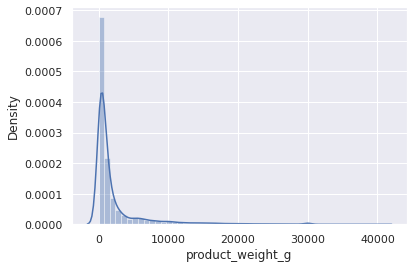

In [32]:
sns.distplot(olist_products['product_weight_g'])

### Olist_sellers Dataset

In [34]:
olist_sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [35]:
olist_sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [36]:
olist_sellers.isnull().mean()*100

seller_id                 0.0
seller_zip_code_prefix    0.0
seller_city               0.0
seller_state              0.0
dtype: float64

### Olist_geolocation Dataset

In [37]:
olist_geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [38]:
olist_geolocation.isnull().mean()*100

geolocation_zip_code_prefix    0.0
geolocation_lat                0.0
geolocation_lng                0.0
geolocation_city               0.0
geolocation_state              0.0
dtype: float64

In [39]:
lat = olist_geolocation['geolocation_lat']
lon = olist_geolocation['geolocation_lng']

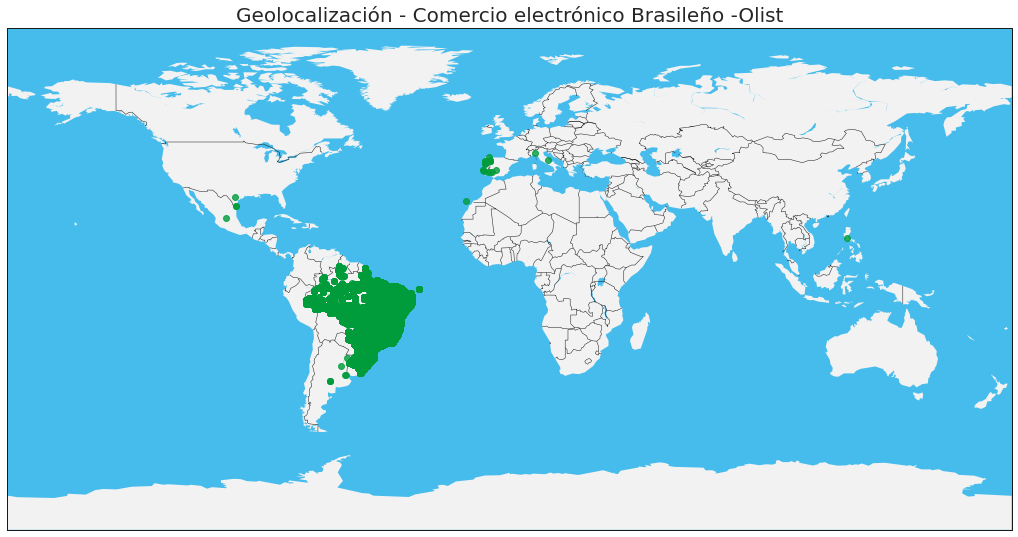

In [40]:
plt.figure(figsize=(18,18))

m = Basemap()
#dibuja un límite alrededor del mapa, rellena el fondo.
# este fondo terminará siendo el color del océano, ya que
# los continentes se dibujarán en la parte superior.
m.drawmapboundary(fill_color='#46bcec')
# fill continents, establece el color del lago igual que el color del océano.
m.fillcontinents(color='#f2f2f2', lake_color='#46bcec')
# dibuja los límites de los países
m.drawcountries()
# dibuja puntos con marcadores
m.scatter(lon, lat, zorder=10, alpha=0.8, color='#009c3b')
# Se establece el título de la figura
plt.title(label='Geolocalización - Comercio electrónico Brasileño -Olist', fontsize=20)
plt.show()

En la gráfica se visualizan puntos ubicados en zonas geográficas diferentes a Brasil, la cual es nuestra región de interés, por lo tanto se remueven los registros que contienen observaciones fuera de dicha región.

In [41]:
# El punto más septentrional de Brasil está a 5 grados 16′ 27,8″ de latitud norte.
olist_geolocation = olist_geolocation[olist_geolocation.geolocation_lat <= 5.27438888]
# El punto más occidental de Brasil está a 73 grados, 58′ 58.19″W Long
olist_geolocation = olist_geolocation[olist_geolocation.geolocation_lng >= -73.98283055]
# El punto más al sur de Brasil está a 33 grados, 45′ 04.21″ S Latitud
olist_geolocation = olist_geolocation[olist_geolocation.geolocation_lat >= -33.75116944]
# El lugar más oriental de Brasil es 34 grados, 47 ′ 35.33 ″ W Long.
olist_geolocation = olist_geolocation[olist_geolocation.geolocation_lng <=  -34.79314722]

Se realiza nuevamente la visualización del mapa, observándose solo los puntos en la región de interés.

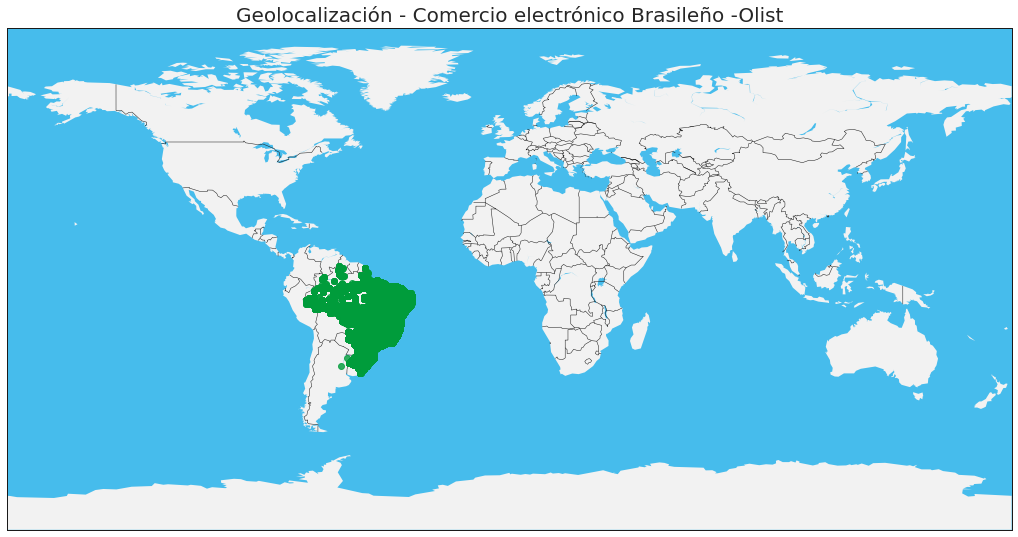

In [42]:
lat = olist_geolocation['geolocation_lat']
lon = olist_geolocation['geolocation_lng']

plt.figure(figsize=(18,18))

m = Basemap()
#dibuja un límite alrededor del mapa, rellena el fondo.
# este fondo terminará siendo el color del océano, ya que
# los continentes se dibujarán en la parte superior.
m.drawmapboundary(fill_color='#46bcec')
# fill continents, establece el color del lago igual que el color del océano.
m.fillcontinents(color='#f2f2f2', lake_color='#46bcec')
# dibuja los límites de los países
m.drawcountries()
# dibuja puntos con marcadores
m.scatter(lon, lat, zorder=10, alpha=0.8, color='#009c3b')
# Se establece el título de la figura
plt.title(label='Geolocalización - Comercio electrónico Brasileño -Olist', fontsize=20)
plt.show()

## DataFrame: exploración del conjunto de datos

A continuación se crea un dataframe a partir de la fusión de tablas que contienen información relacionada. Por ejemplo, la tabla olist_order_items que contiene la información sobre detalles del artículo de compra, fecha de envío, el precio, entre otros, se fusiona con la tabla olist_products la cual contiene la identificación del producto como el ID, categoría y medidas.

In [43]:
order_items_products = pd.merge(olist_order_items,olist_products, on='product_id')
order_items_products_sellers = pd.merge(order_items_products,olist_sellers,on='seller_id')
two_order_items_products_sellers = pd.merge(order_items_products_sellers,olist_orders,on='order_id')
two_order_items_products_sellers_customer = pd.merge(two_order_items_products_sellers,olist_customer,on='customer_id')
two_order_items_products_sellers_customer_reviews = pd.merge(two_order_items_products_sellers_customer,olist_order_reviews,on='order_id')
final_dataframe = pd.merge(two_order_items_products_sellers_customer_reviews,olist_order_payments,on='order_id')

In [44]:
order_items_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111046 entries, 0 to 111045
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   order_id                    111046 non-null  object 
 1   order_item_id               111046 non-null  int64  
 2   product_id                  111046 non-null  object 
 3   seller_id                   111046 non-null  object 
 4   shipping_limit_date         111046 non-null  object 
 5   price                       111046 non-null  float64
 6   freight_value               111046 non-null  float64
 7   product_category_name       111046 non-null  object 
 8   product_name_lenght         111046 non-null  float64
 9   product_description_lenght  111046 non-null  float64
 10  product_photos_qty          111046 non-null  float64
 11  product_weight_g            111046 non-null  float64
 12  product_length_cm           111046 non-null  float64
 13  product_height

In [45]:
final_dataframe.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,...,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,...,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,1,credit_card,2,72.19
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,cool_stuff,58.0,598.0,...,b11cba360bbe71410c291b764753d37f,5,NaN,"lannister como sempre, entregou certinho e den...",2017-07-14 00:00:00,2017-07-17 12:50:07,1,boleto,1,73.86
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,cool_stuff,58.0,598.0,...,af01c4017c5ab46df6cc810e069e654a,4,super recomendo,carrinho muito bonito,2018-06-05 00:00:00,2018-06-06 21:41:12,1,credit_card,2,83.23


In [46]:
final_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115633 entries, 0 to 115632
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115633 non-null  object 
 1   order_item_id                  115633 non-null  int64  
 2   product_id                     115633 non-null  object 
 3   seller_id                      115633 non-null  object 
 4   shipping_limit_date            115633 non-null  object 
 5   price                          115633 non-null  float64
 6   freight_value                  115633 non-null  float64
 7   product_category_name          115633 non-null  object 
 8   product_name_lenght            115633 non-null  float64
 9   product_description_lenght     115633 non-null  float64
 10  product_photos_qty             115633 non-null  float64
 11  product_weight_g               115633 non-null  float64
 12  product_length_cm             

In [53]:
final_dataframe.to_csv('final_dataframe.csv') 

In [47]:
print(final_dataframe.columns)
final_dataframe.shape

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state', 'customer_id',
       'order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')


(115633, 39)

In [48]:
final_dataframe = final_dataframe.drop_duplicates(subset=['order_id','order_purchase_timestamp','product_id','customer_unique_id','review_comment_message'])
final_dataframe.shape

(100423, 39)

In [49]:
final_dataframe.drop(['order_id','product_id','seller_id','customer_unique_id'], axis=1, inplace=True)
final_dataframe.columns

Index(['order_item_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state', 'customer_id',
       'order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value'],
      dtype='object')

In [50]:
final_dataframe['product_category_name'].fillna(value=final_dataframe['product_category_name'].mode()[0], inplace=True)
final_dataframe['product_name_lenght'].fillna(value=final_dataframe['product_name_lenght'].mode()[0], inplace=True)
final_dataframe['product_description_lenght'].fillna(value=final_dataframe['product_description_lenght'].median(), inplace=True)
final_dataframe['product_photos_qty'].fillna(value=final_dataframe['product_photos_qty'].mode()[0], inplace=True)
final_dataframe['product_weight_g'].fillna(value=final_dataframe['product_weight_g'].mode()[0], inplace=True)
final_dataframe['product_length_cm'].fillna(value=final_dataframe['product_length_cm'].mode()[0], inplace=True)
final_dataframe['product_height_cm'].fillna(value=final_dataframe['product_height_cm'].mode()[0], inplace=True)
final_dataframe['product_width_cm'].fillna(value=final_dataframe['product_width_cm'].mode()[0], inplace=True)
final_dataframe['review_comment_message'].fillna(value='indisponível', inplace=True)

In [51]:
final_dataframe['review_score'] = final_dataframe['review_score'].apply(lambda x: 1 if x > 3 else 0)

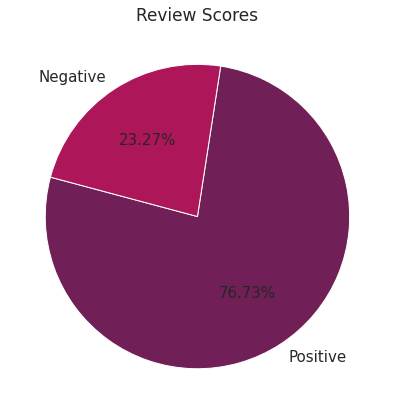

In [52]:
plt.figure(figsize=(7,7))
final_dataframe['review_score'].map({0:'Negative',1:'Positive'}).value_counts().plot.pie(autopct='%.2f%%', textprops={'fontsize':15}, startangle=165, colors=['#701f57','#ad1759','#f6b48f'])
plt.title('Review Scores', fontsize=17)
plt.ylabel('')
plt.show()

In [54]:
final_dataframe[['price','freight_value','product_name_lenght','product_description_lenght','product_weight_g','product_length_cm', 'product_height_cm', 'product_height_cm',	'product_width_cm']].describe()

,price,freight_value,product_name_lenght,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_height_cm,product_width_cm
count,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000,100423.000000
mean,124.297566,20.140452,48.877578,786.802764,2093.805821,30.134461,16.426576,16.426576,23.079733
std,187.138168,15.904433,9.994350,650.349525,3751.133349,16.123804,13.325117,13.325117,11.752841
min,0.850000,0.000000,5.000000,4.000000,0.000000,7.000000,2.000000,2.000000,6.000000
25%,40.350000,13.160000,43.000000,348.000000,300.000000,18.000000,8.000000,8.000000,15.000000
50%,78.500000,16.350000,52.000000,602.000000,700.000000,25.000000,13.000000,13.000000,20.000000
75%,139.000000,21.260000,57.000000,985.000000,1800.000000,38.000000,20.000000,20.000000,30.000000
max,6735.000000,409.680000,76.000000,3992.000000,40425.000000,105.000000,105.000000,105.000000,118.000000


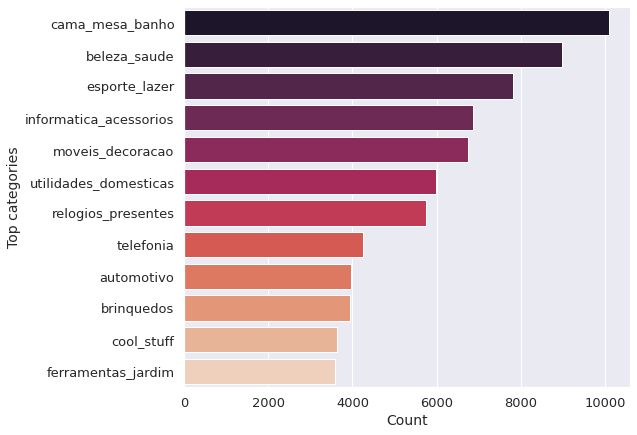

In [55]:
plt.figure(figsize=(8,7))
idx = final_dataframe['product_category_name'].value_counts()[:12].index
sns.countplot(y=final_dataframe['product_category_name'], order=idx, palette="rocket")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Top categories', fontsize=14)
plt.show()

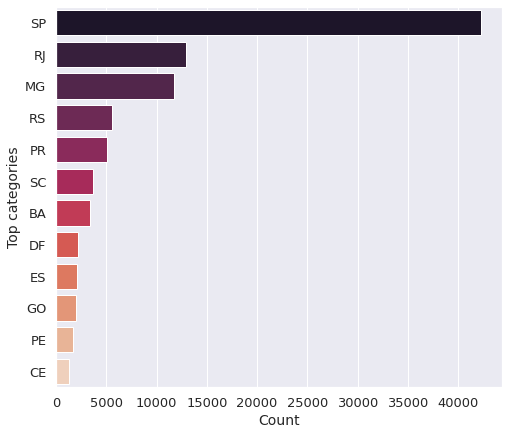

In [56]:
plt.figure(figsize=(8,7))
idx = final_dataframe['customer_state'].value_counts()[:12].index
sns.countplot(y=final_dataframe['customer_state'], order=idx, palette="rocket")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Top categories', fontsize=14)
plt.show()

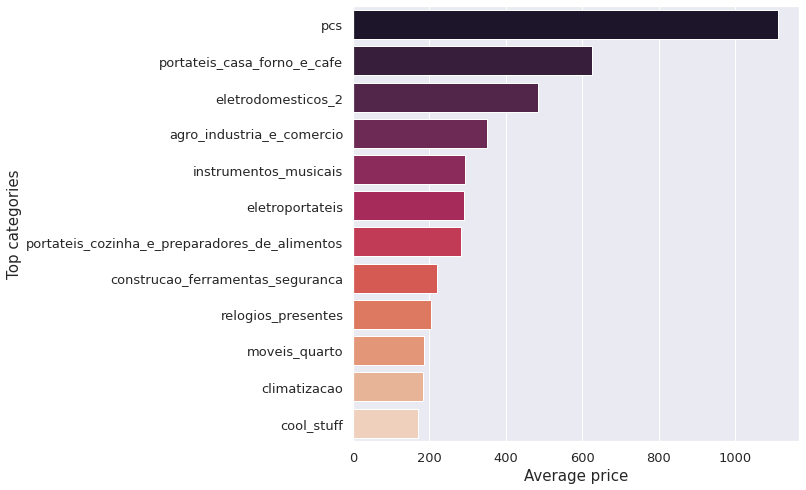

In [57]:
grp_cat_name = final_dataframe.groupby('product_category_name')
grp_dict = dict(grp_cat_name.mean()['price'].sort_values(ascending=False)[:12])
plt.figure(figsize=(8,8))
sns.barplot(y=list(grp_dict.keys()),x=list(grp_dict.values()), palette="rocket")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Average price', fontsize=15)
plt.ylabel('Top categories', fontsize=15)
plt.show()

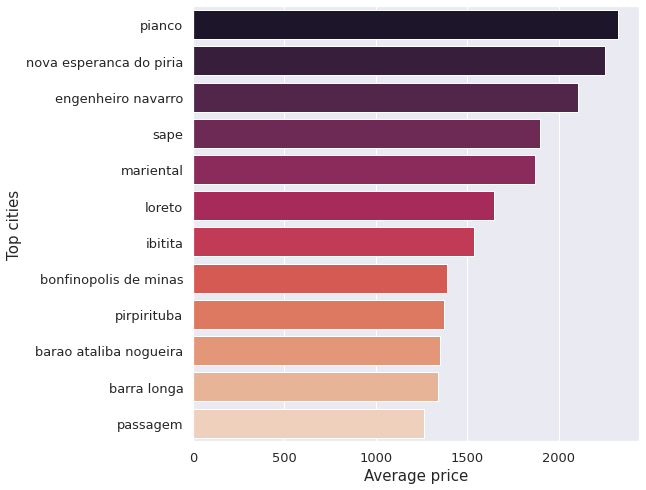

In [58]:
grp_state_name = final_dataframe.groupby('customer_city')
grp_dict = dict((grp_state_name.mean()['price']+grp_state_name.mean()['freight_value']).sort_values(ascending=False)[:12])
plt.figure(figsize=(8,8))
sns.barplot(y=list(grp_dict.keys()),x=list(grp_dict.values()), palette="rocket")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Average price', fontsize=15)
plt.ylabel('Top cities', fontsize=15)
plt.show()

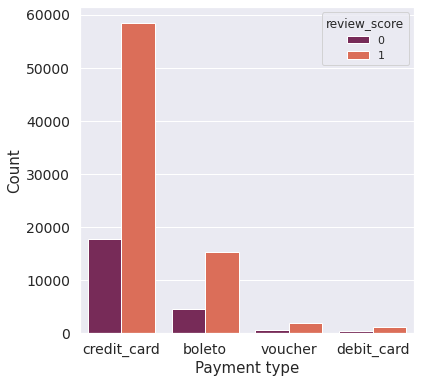

In [59]:
plt.figure(figsize=(6,6))
sns.countplot(data=final_dataframe,x='payment_type', hue='review_score', palette='rocket')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Payment type', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()